In [1]:
import torch
import torch.optim as optim
import numpy as np
import time
from datasets import Robot_Traj_Dataset_Experiment_Sim
from torch.utils.data import DataLoader,Dataset

import matplotlib.pyplot as plt

from losses import log_prob_loss, task_loss_rgb, task_loss, task_loss_with_deform
from networks import NFSMP_Image, NFSMP_Image_Inference
from visualize import img_predict, img_predict_inference, img_predict_interp
from evaluate import traj_field, validate, test
import pickle
import cv2
import copy
from tqdm import tqdm

%matplotlib inline

train = False

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


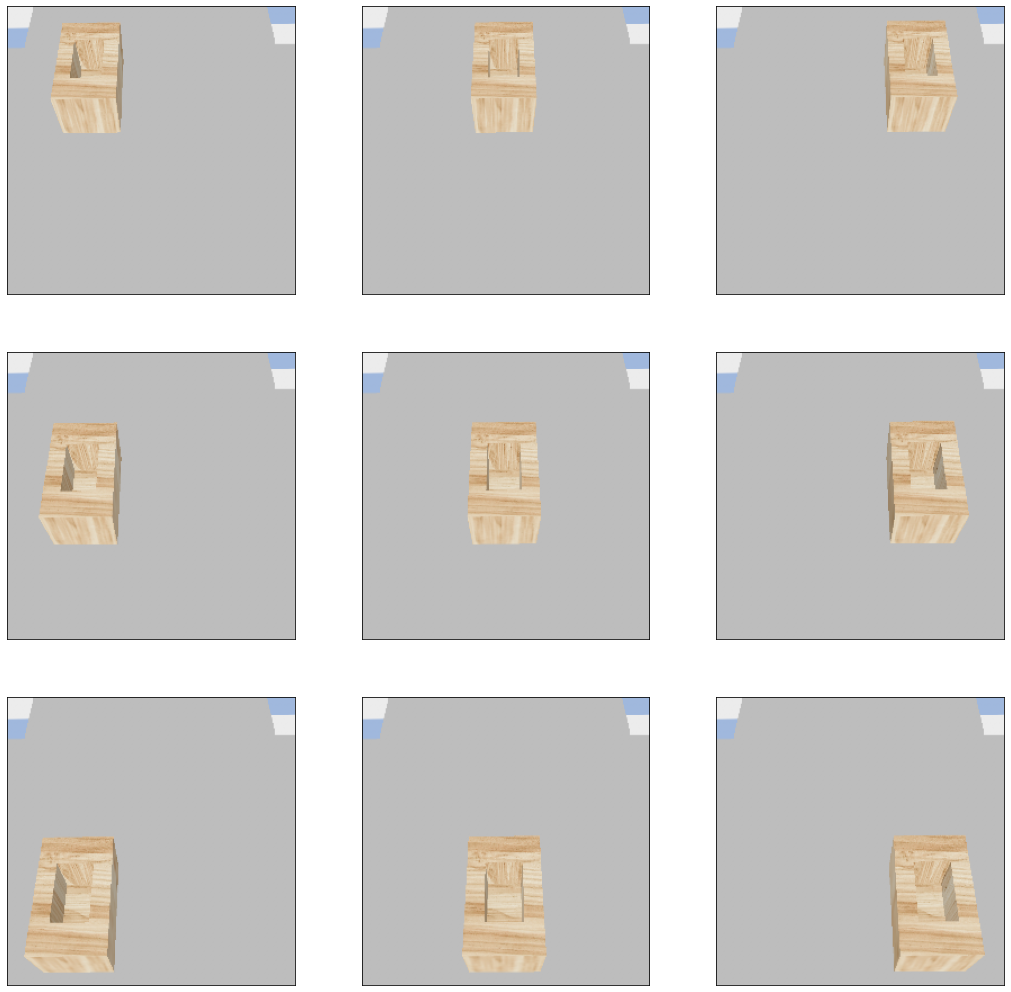

In [2]:
traj_count = 9
task = "ur10_peg_in_hole_3x3"
task_id = 1
dataset = Robot_Traj_Dataset_Experiment_Sim(task,traj_count,task_id)
dataloader = DataLoader(dataset, shuffle=True,batch_size=3, num_workers=0, drop_last = True)
fig,ax=plt.subplots(3,3,figsize=(18,18))
for i in range(9):
    ax[i//3,i%3].imshow(dataset.demo_img[i]/255.0)
    ax[i//3,i%3].get_xaxis().set_visible(False)
    ax[i//3,i%3].get_yaxis().set_visible(False)
plt.show()

In [3]:
if train:
    total_steps=0
    epochs = 1500
    lowest_mp_loss = 1000
    for seed in range(10):
        model = NFSMP_Image(traj_count,L=8,L2=2)
        model.to(device=torch.device('cuda:0'))
        optim = torch.optim.Adam([
                        {'params': model.mp_net.parameters()},
                        {'params': model.rgb_net.parameters()},
                        {'params': model.deform_net.parameters()},
                        {'params': model.hyper_net_mp.parameters()},
                        {'params': model.hyper_net_deform.parameters()},
                        {'params': model.latent_codes.parameters(),'lr':1e-4},
                    ],
            lr=1e-3)
        lowest_mp_loss_epoch = 1000
        with tqdm(total = len(dataloader) * epochs) as pbar:
            train_losses = []
            for epoch in range(epochs):
                if epoch%200==199:
                    img_predict_interp(model,128,epoch=epoch)
                model.train()
                epoch_mp_losses = []        
                for step, (model_input, gt) in enumerate(dataloader):

                    start_time = time.time()
                    model_input = {key: value.cuda() for key, value in model_input.items()}
                    gt = {key: value.cuda() for key, value in gt.items()}

                    losses = model(model_input,gt,epoch)

                    train_loss = 0.
                    for loss_name, loss in losses.items():
                        single_loss = loss.mean()
                        if epoch %100== 0 and step==0:
                            print(loss_name,single_loss)
                        train_loss += single_loss            

                    epoch_mp_losses.append(train_loss.item())            
                    train_losses.append(losses['mp'].item())
                    optim.zero_grad()
                    train_loss.backward()
                    optim.step()
                    pbar.update(1)
                    pbar.set_postfix(loss=train_loss.item(), time=time.time() - start_time, epoch=epoch)
                    total_steps += 1
                if epoch>1000 and epoch%20==0:
                    curr_error = validate(model, experiment_name=task,num_of_traj=traj_count,task_id=task_id)
                    if curr_error<lowest_mp_loss:
                        print(curr_error,epoch)
                        lowest_mp_loss=curr_error
                        checkpoint = copy.deepcopy(model.state_dict())
else:
    model = NFSMP_Image(traj_count,L=8,L2=2)
    model.to(device=torch.device('cuda:0'))
    model.load_state_dict(torch.load("sim_exp_1"))
    model.eval()

SingleBVPNet(
  (net): FCBlock(
    (net): MetaSequential(
      (0): MetaSequential(
        (0): BatchLinear(
          in_features=17, out_features=256, bias=True
          (softplus): Softplus(beta=1, threshold=20)
        )
        (1): ReLU(inplace=True)
      )
      (1): MetaSequential(
        (0): BatchLinear(
          in_features=256, out_features=256, bias=True
          (softplus): Softplus(beta=1, threshold=20)
        )
        (1): ReLU(inplace=True)
      )
      (2): MetaSequential(
        (0): BatchLinear(
          in_features=256, out_features=256, bias=True
          (softplus): Softplus(beta=1, threshold=20)
        )
        (1): ReLU(inplace=True)
      )
      (3): MetaSequential(
        (0): BatchLinear(
          in_features=256, out_features=256, bias=True
          (softplus): Softplus(beta=1, threshold=20)
        )
        (1): ReLU(inplace=True)
      )
      (4): MetaSequential(
        (0): BatchLinear(
          in_features=256, out_features=6, bi

In [4]:
if train:
    model.load_state_dict(checkpoint)
    torch.save(model.state_dict(), "sim_exp_1")
    print(lowest_mp_loss)
    model.eval()

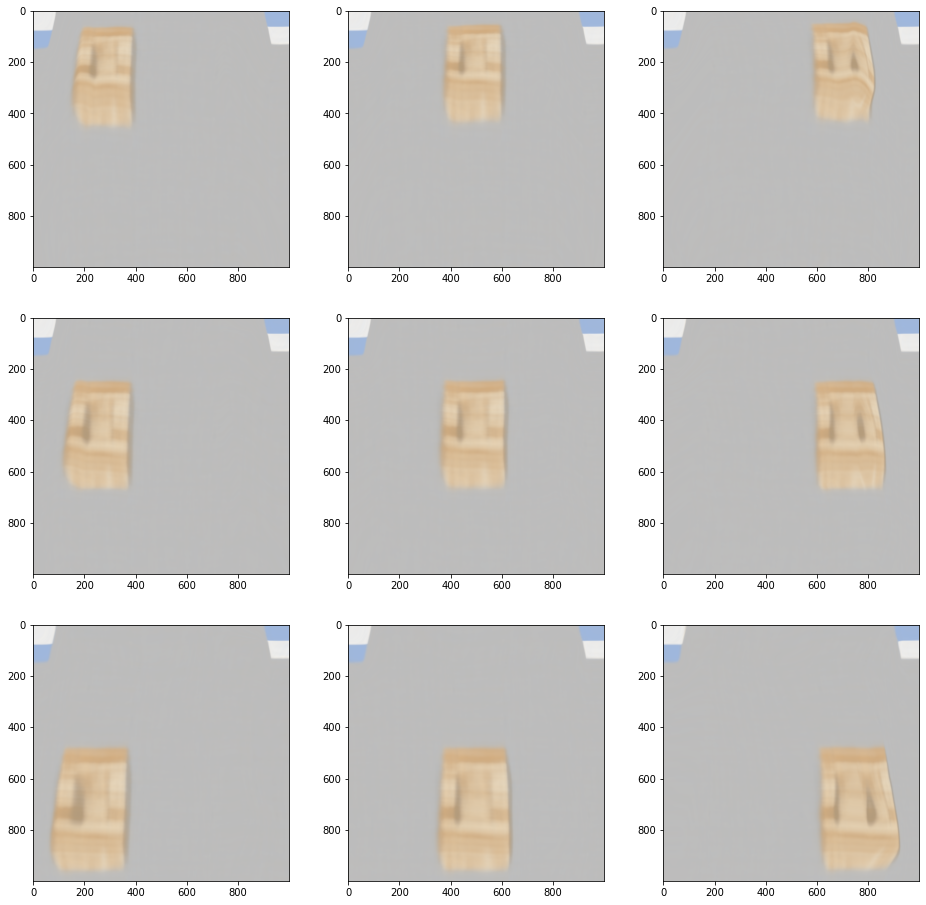

In [5]:
%matplotlib inline
img_predict(model,1000)

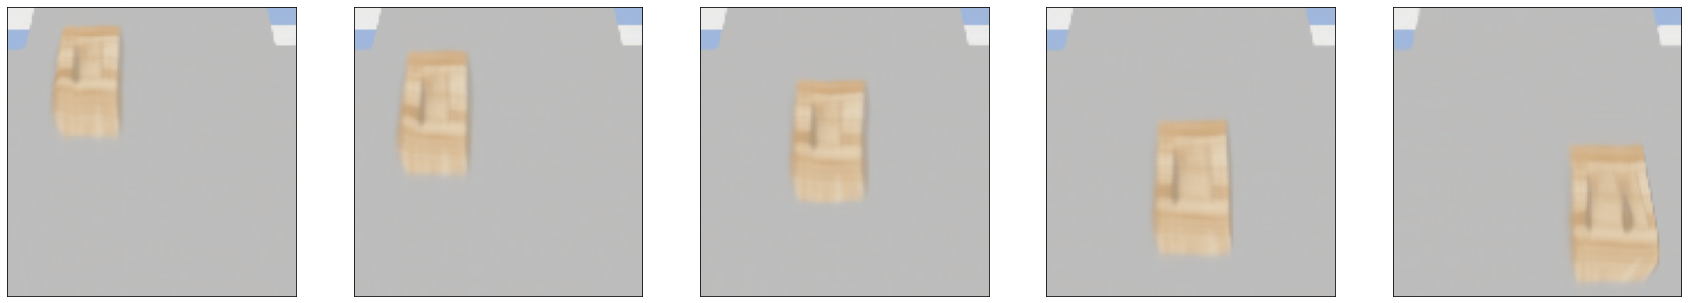

In [6]:
img_predict_interp(model,128,1000,0,8)

In [7]:
%matplotlib inline
tests={
    "3x3":("ur10_peg_in_hole_3x3",9),
    "4x4":("ur10_peg_in_hole_4x4",16),
    "5x5":("ur10_peg_in_hole_5x5",25),
}
test_datasets = dict()
test_dataloaders = dict()
test_models = dict()
for label in tests:
    test_datasets[label] = Robot_Traj_Dataset_Experiment_Sim(tests[label][0],tests[label][1],task_id)
    test_dataloaders[label] = DataLoader(test_datasets[label], shuffle=False,batch_size=40, num_workers=0, drop_last = False)  
    test_models[label] = NFSMP_Image_Inference(tests[label][1],model)

  2%|▏         | 3/200 [00:00<00:14, 13.85it/s, epoch=1, loss=70.7, time=0.0697]

rgb tensor(73.0575, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|███▉    | 99/200 [00:07<00:07, 12.84it/s, epoch=98, loss=11.7, time=0.0694]

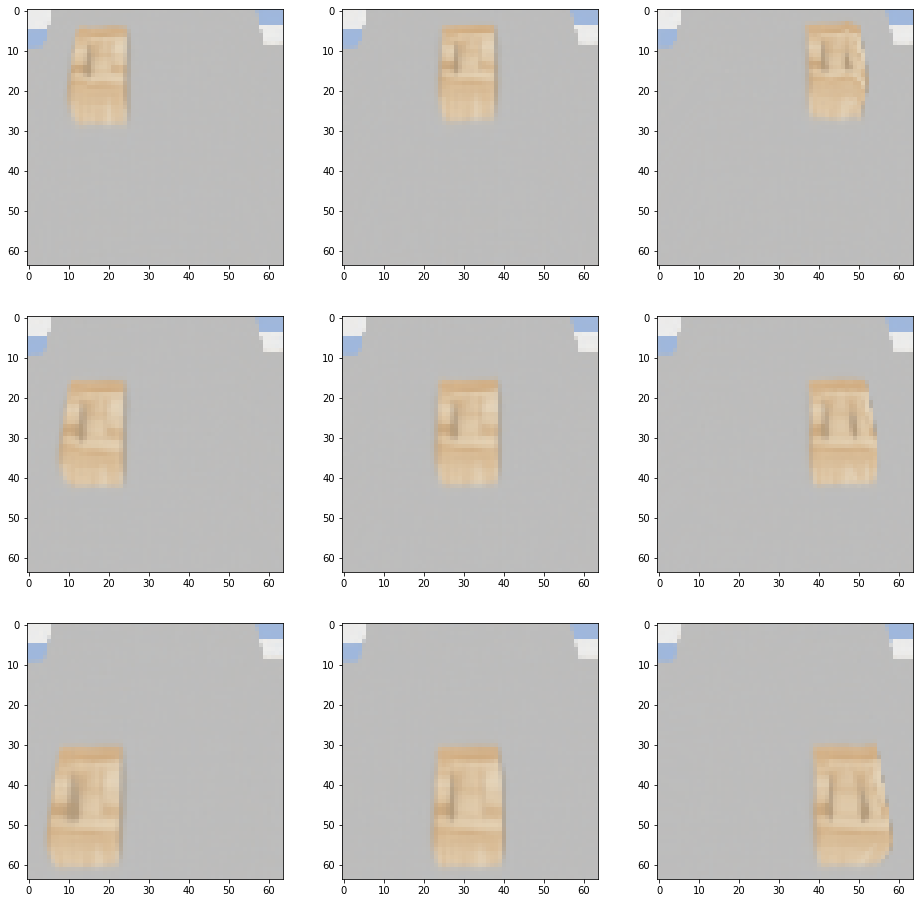

 52%|███   | 103/200 [00:08<00:14,  6.57it/s, epoch=101, loss=11.4, time=0.0693]

rgb tensor(11.5237, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████▉| 199/200 [00:16<00:00, 12.93it/s, epoch=198, loss=11.4, time=0.069]

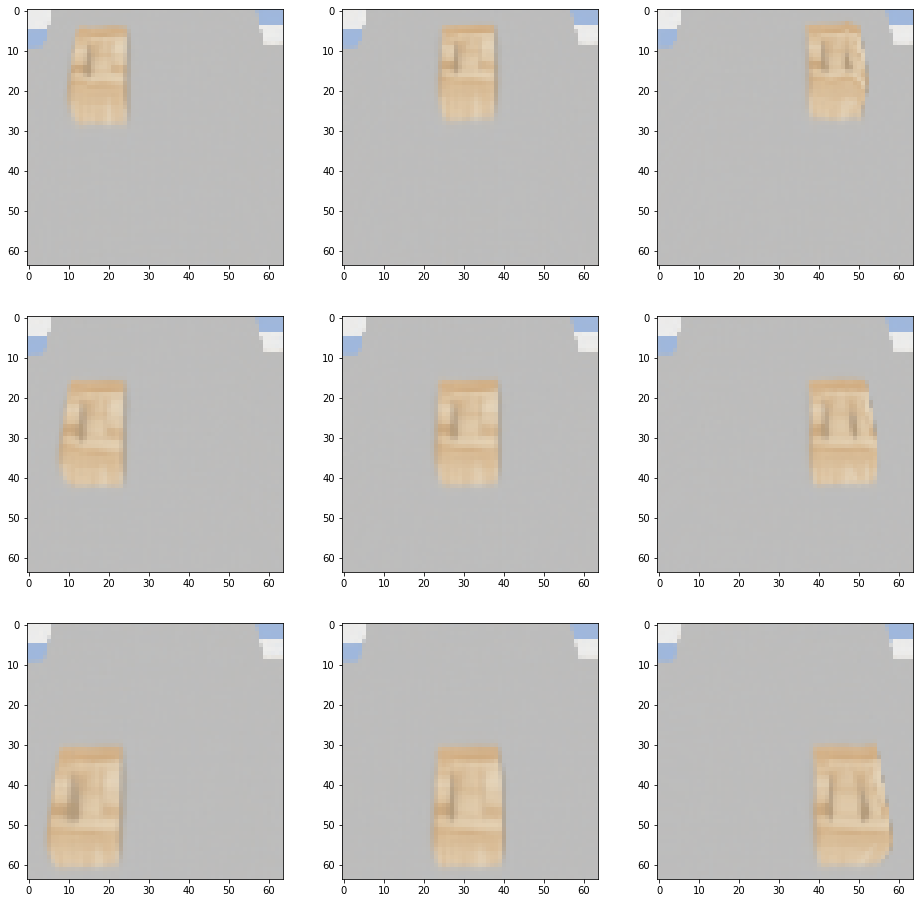

  1%|            | 2/200 [00:00<00:16, 12.02it/s, epoch=0, loss=69.4, time=0.11]

rgb tensor(69.3593, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|████▍    | 99/200 [00:12<00:12,  7.83it/s, epoch=98, loss=13.2, time=0.111]

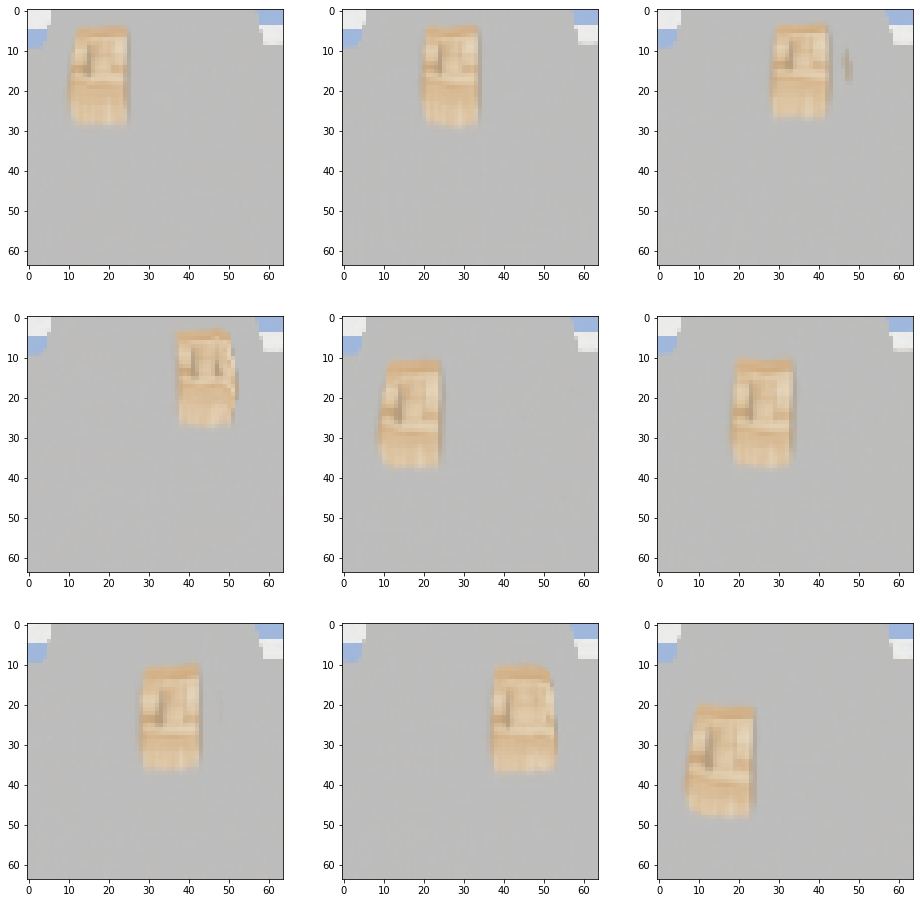

 51%|███▌   | 102/200 [00:13<00:21,  4.64it/s, epoch=100, loss=13.2, time=0.112]

rgb tensor(13.2432, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████▉| 199/200 [00:25<00:00,  8.00it/s, epoch=198, loss=13.4, time=0.111]

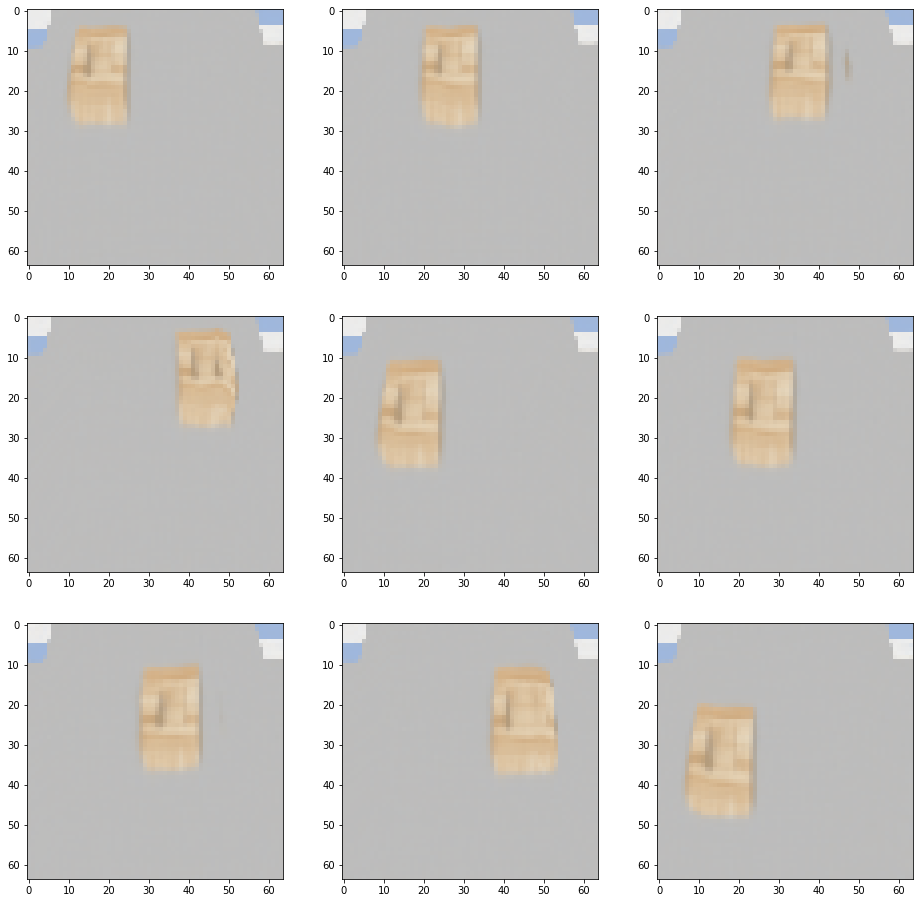

  0%|           | 1/200 [00:00<00:38,  5.23it/s, epoch=0, loss=73.1, time=0.173]

rgb tensor(73.0632, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|████▍    | 99/200 [00:18<00:19,  5.20it/s, epoch=98, loss=18.3, time=0.173]

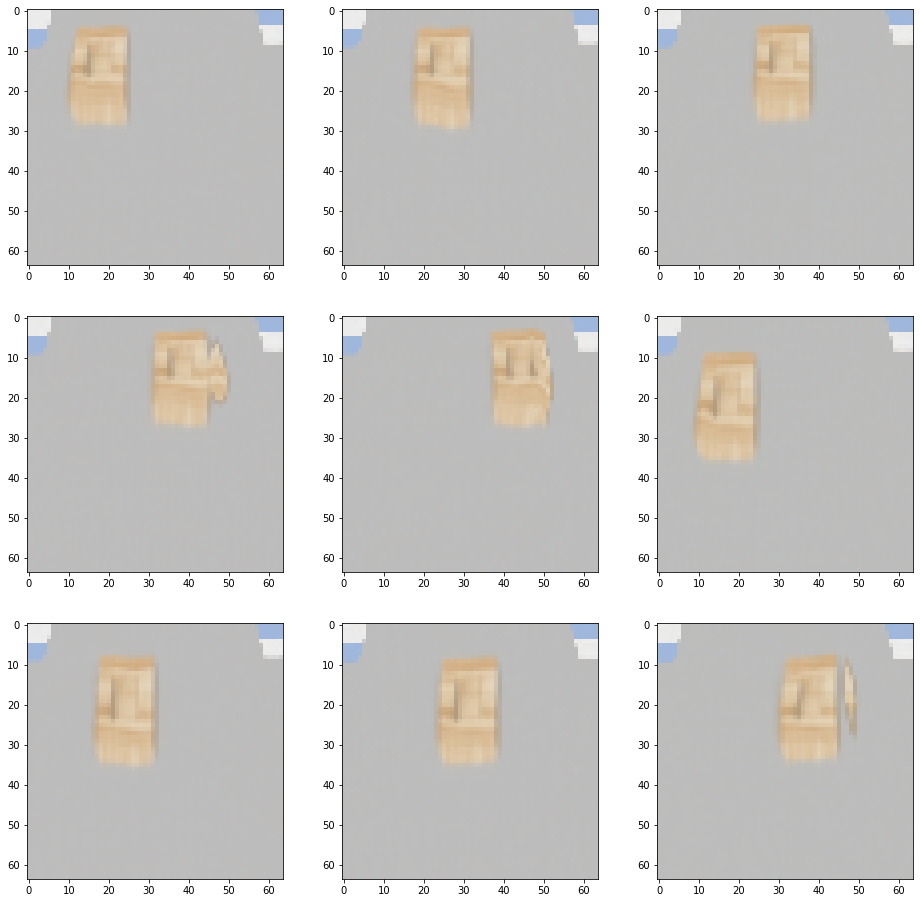

 51%|███▌   | 102/200 [00:19<00:27,  3.60it/s, epoch=100, loss=19.3, time=0.172]

rgb tensor(19.3093, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████▉| 199/200 [00:38<00:00,  5.30it/s, epoch=198, loss=19.1, time=0.171]

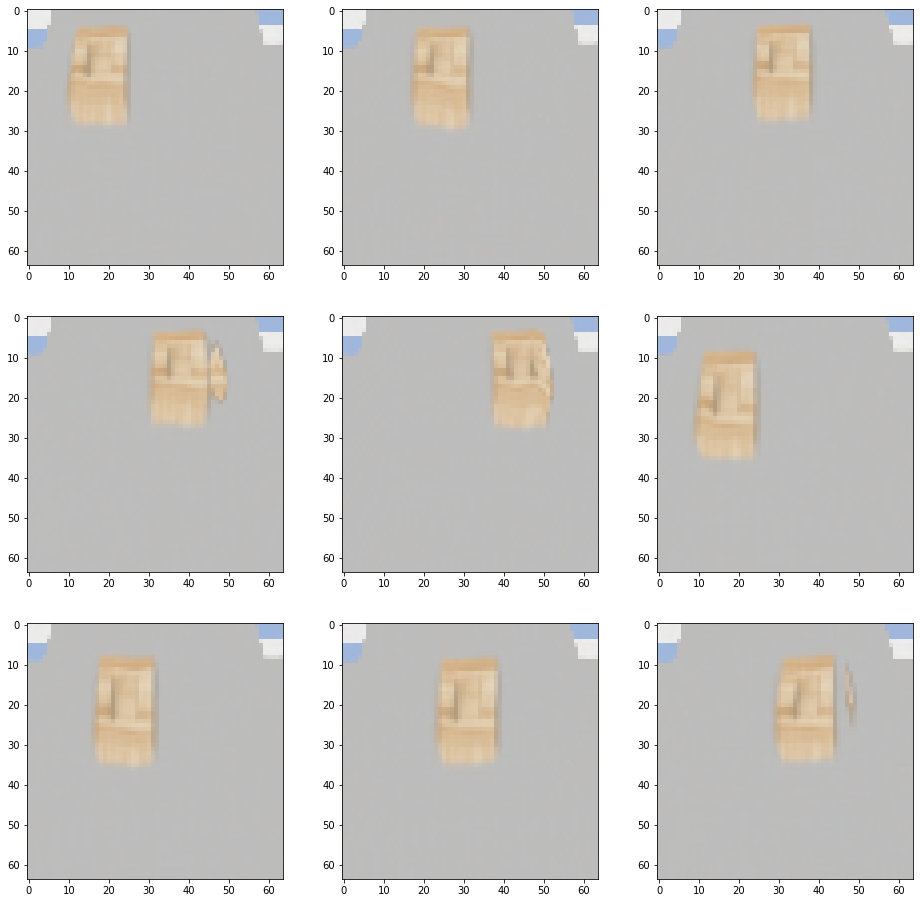

100%|█████████| 200/200 [00:39<00:00,  5.07it/s, epoch=199, loss=18, time=0.171]


In [8]:
for label in tests.keys():
    test_model = test_models[label]
    test_model.to(device=torch.device('cuda:0'))
    test_dataloader = test_dataloaders[label]
    test(test_model, test_dataloader)
    

In [9]:
for label in tests.keys():
    test_model = test_models[label]
    predicted_traj = traj_field(test_model, 100, 1000, number_of_traj = tests[label][1])
    errors = list()
    for i in range(tests[label][1]):
        errors.append(np.linalg.norm(predicted_traj[i]-test_datasets[label].demo_q[i],axis=-1).mean()/np.pi*180) 
    print(label, np.mean(errors))

3x3 0.8750995833670285
4x4 2.4164610884285938
5x5 2.369592095394008
